<a href="https://colab.research.google.com/github/hkiiskin/ML-Project1/blob/main/S%26P_500_Stock_Data_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Libraries

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC

from torchsummary import summary

import pytorch_lightning as pl

## Load & preprocess the Dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498044 entries, 252 to 619039
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        498044 non-null  datetime64[ns]
 1   open        498033 non-null  float64       
 2   high        498036 non-null  float64       
 3   low         498036 non-null  float64       
 4   close       498044 non-null  float64       
 5   volume      498044 non-null  int64         
 6   Name        498044 non-null  int64         
 7   open_close  498033 non-null  float64       
 8   by_year     498044 non-null  int64         
 9   by_month    498044 non-null  int64         
 10  by_date     498044 non-null  int64         
 11  by_day      498044 non-null  int64         
 12  week        498044 non-null  int64         
 13  month       498044 non-null  int64         
 14  year        498044 non-null  int64         
 15  target      498044 non-null  int64         
dtype

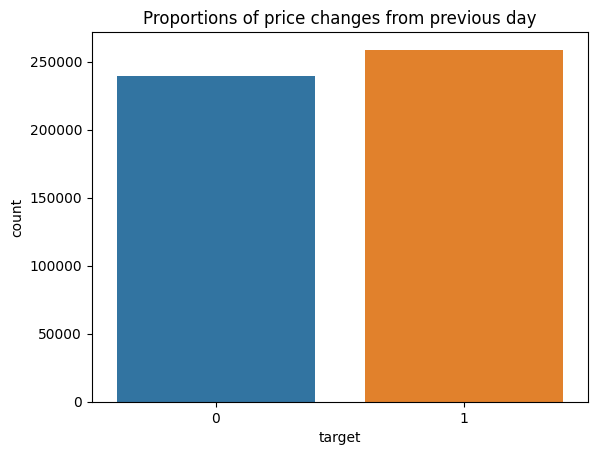

,date,open,high,low,close,volume,Name,open_close,by_year,by_month,by_date,by_day,week,month,year,target
252,2014-02-10,36.10,36.150,35.38,35.580,11110235,1,-0.520,2014,2,10,0,0,1,1,0
253,2014-02-11,35.58,35.640,34.39,35.130,11990875,1,-0.450,2014,2,11,1,0,1,1,0
254,2014-02-12,34.89,35.000,34.36,34.690,9386780,1,-0.200,2014,2,12,2,1,1,1,1
255,2014-02-13,34.07,35.040,34.06,35.025,8412272,1,0.955,2014,2,13,3,1,1,1,0
256,2014-02-14,34.85,35.176,34.22,34.410,7307286,1,-0.440,2014,2,14,4,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.270,76.69,77.820,2982259,504,0.980,2018,2,1,3,0,0,0,0
619036,2018-02-02,77.53,78.120,76.73,76.780,2595187,504,-0.750,2018,2,2,4,0,0,0,0
619037,2018-02-05,76.64,76.920,73.18,73.830,2962031,504,-2.810,2018,2,5,0,0,0,0,0
619038,2018-02-06,72.74,74.560,72.13,73.270,4924323,504,0.530,2018,2,6,1,0,0,0,1


In [3]:
class Load_Preprocess():
    def __init__(self, path='all_stocks_5yr.csv'):
        self.df = pd.read_csv(path)
        self.Target_proportions()

    def Target_proportions(self):
        # Change format
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df['Name'] = self.df['Name'].astype('string')
        label_encoder = preprocessing.LabelEncoder()
        # Encode labels in column 'call2'.
        self.df['Name']= label_encoder.fit_transform(self.df['Name'])

        # Define more features
        self.df['open_close'] = (self.df['close'] - self.df['open'])
        self.df['by_year'] = self.df['date'].dt.year
        self.df['by_month'] = self.df['date'].dt.month
        self.df['by_date'] = self.df['date'].dt.day
        self.df['by_day'] = self.df['date'].dt.dayofweek
        self.df['week'] = (self.df['close'].shift(-5) > self.df['close']).astype(int)
        self.df['month'] = (self.df['close'].shift(-21) > self.df['close']).astype(int)
        self.df['year'] = (self.df['close'].shift(-260) > self.df['close']).astype(int)
        self.df.drop(self.df[self.df.date < '2014-02-08'].index, inplace=True)

        # Define target based on +/- from previous day
        self.df['target'] = (self.df['close'].shift(-1) > self.df['close']).astype(int)
        print(self.df.info())
        sns.countplot(x=self.df['target']).set_title('Proportions of price changes from previous day')
        plt.show()

    # def Rebalance_Target_Data(self, X_train, y_train):
    #     print('Before under-Sampling:')
    #     print('Class 0 count:', np.sum(y_train == 0))
    #     print('Class 1 count:', np.sum(y_train == 1))

    #     rus = RandomUnderSampler(random_state=42)
    #     X_under, y_under = rus.fit_resample(X_train, y_train)

    #     print('After under-Sampling:')
    #     print('Class 0 count:', np.sum(y_under == 0))
    #     print('Class 1 count:', np.sum(y_under == 1))

    #     return X_under, y_under

    def Preprocessing(self):
        X = self.df.iloc[:, 1:14].to_numpy()
        y = self.df.iloc[:, 15].to_numpy()

        # Scale the the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        # X_under, y_under = self.Rebalance_Target_Data(X_train, y_train)

        return X_train, X_val, X_test, y_train, y_val, y_test

LP = Load_Preprocess()
X_train, X_val, X_test, y_train, y_val, y_test = LP.Preprocessing()
LP.df

In [4]:
X_train.shape, y_train.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((398435, 13), (398435,), (49804, 13), (49805, 13), (49804,), (49805,))

# Neural Networks

In [5]:
class Stock_Dataset(Dataset):
    def __init__(self, Features, Labels):
        self.features = Features
        self.labels = Labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y = self.features[idx], self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_data = Stock_Dataset(X_train, y_train)
val_data = Stock_Dataset(X_val, y_val)
test_data = Stock_Dataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)#, drop_last=True
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [6]:
train_data.__len__(), val_data.__len__(), test_data.__len__(),

(398435, 49804, 49805)

In [7]:
train_data.__getitem__(0)#, val_data.__getitem__(0), test_data.__getitem__(0),

(tensor([-0.1304, -0.1283, -0.1278, -0.1274, -0.1673,  1.3374,  0.1831,  0.3312,
          0.7128,  0.3730, -1.4460,  0.9196, -1.1384]),
 tensor(1))

In [8]:
train_data.__getitem__(0)[0].shape

torch.Size([13])

In [18]:
class Stock_Classier(pl.LightningModule):
    def __init__(self):
        super(Stock_Classier, self).__init__()
        self.hidden1 = nn.Linear(13, 256)
        self.hidden2 = nn.Linear(256, 128)
        # self.bn = nn.BatchNorm1d(128)
        # self.hidden3 = nn.Linear(128, 128)
        # self.dropout = nn.Dropout(p=0.5)
        self.hidden4 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 2)

        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.LeakyReLU(0.25)
        self.CE = nn.CrossEntropyLoss()
        # self.CE = nn.BCEWithLogitsLoss()

    def forward(self, x):
        out = self.activation(self.hidden1(x))
        out = self.activation(self.hidden2(out))
        # out = self.bn(out)
        # out = self.activation(self.hidden3(out))
        # out = self.dropout(out)
        out = self.activation(self.hidden4(out))

        out = self.output(out)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('test_loss', loss)
        self.log('test_acc', acc, prog_bar=True)

    def predict_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)

        # Apply softmax to get probability distribution over classes
        probabilities = F.softmax(preds, dim=1)

        # Get class predictions by finding the class with the highest probability
        _, predicted_classes = torch.max(probabilities, dim=1)

        return predicted_classes.tolist()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)
        # return torch.optim.SGD(self.parameters(), lr=0.0001)

In [19]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Model = Stock_Classier().to(device)
print(Model)
device

Stock_Classier(
  (hidden1): Linear(in_features=13, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden4): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
  (activation): LeakyReLU(negative_slope=0.25)
  (CE): CrossEntropyLoss()
)


'cuda'

In [20]:
trainer = pl.Trainer(max_epochs=10, gradient_clip_val=1.0)#, gradient_clip_val=1.0
trainer.fit(Model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | hidden1    | Linear           | 3.6 K 
1 | hidden2    | Linear           | 32.9 K
2 | hidden4    | Linear           | 4.1 K 
3 | output     | Linear           | 66    
4 | activation | LeakyReLU        | 0     
5 | CE         | CrossEntropyLoss | 0     
------------------------------------------------
40.7 K    Trainable params
0         Non-trainable params
40.7 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [102]:
predictions = trainer.predict(Model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [103]:
np.array(predictions[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [114]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.hidden1 = nn.Linear(10, 64)
        self.hidden2 = nn.Linear(64, 128)

        self.bn = nn.BatchNorm1d(128)

        self.hidden3 = nn.Linear(128, 128)
        self.hidden4 = nn.Linear(128, 256)

        self.activation = nn.LeakyReLU(0.25)
        self.output = nn.Linear(256, 2)

    def forward(self, x):
        out = self.activation(self.hidden1(x))
        out = self.activation(self.hidden2(out))
        out = self.bn(out)
        out = self.activation(self.hidden3(out))
        out = self.activation(self.hidden4(out))

        out = self.output(out)
        return out

class St_Classifier(pl.LightningModule):
    def __init__(self):
        super(St_Classifier, self).__init__()

        self.model = Classifier()
        self.CE = nn.CrossEntropyLoss()

        self.Acc_batch = []
        self.Avg_Acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        preds = self.forward(features)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True)

        self.Acc_batch.append(acc)

        return loss

    def on_train_epoch_end(self):
        stacked_tensors = torch.stack(self.Acc_batch, dim=0)
        average_tensor = torch.mean(stacked_tensors, dim=0)

        self.Avg_Acc.append(average_tensor)
        self.Acc_batch.clear()

    def validation_step(self, batch, batch_idx):
        features, labels = batch
        preds = self(features)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        features, labels = batch
        preds = self(features)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        features, labels = batch
        preds = self(features)

        probabilities = F.softmax(preds, dim=1)
        _, predicted_classes = torch.max(probabilities, dim=1)

        return (probabilities, predicted_classes.tolist())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)# Initialize the data module
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=5, mode='min', verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": 'val_loss'}

In [115]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Model = St_Classifier().to(device)
print(Model)

St_Classifier(
  (model): Classifier(
    (hidden1): Linear(in_features=10, out_features=64, bias=True)
    (hidden2): Linear(in_features=64, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden3): Linear(in_features=128, out_features=128, bias=True)
    (hidden4): Linear(in_features=128, out_features=256, bias=True)
    (activation): LeakyReLU(negative_slope=0.25)
    (output): Linear(in_features=256, out_features=2, bias=True)
  )
  (CE): CrossEntropyLoss()
)


In [116]:
trainer = pl.Trainer(max_epochs=100, gradient_clip_val=1.0)#
trainer.fit(Model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Classifier       | 59.3 K
1 | CE    | CrossEntropyLoss | 0     
-------------------------------------------
59.3 K    Trainable params
0         Non-trainable params
59.3 K    Total params
0.237     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 6.0000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 3.6000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 2.1600e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 1.2960e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 7.7760e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 4.6656e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 2.7994e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 1.6796e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00054: reducing learning rate of group 0 to 1.0078e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00060: reducing learning rate of group 0 to 6.0466e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00066: reducing learning rate of group 0 to 3.6280e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00072: reducing learning rate of group 0 to 2.1768e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00078: reducing learning rate of group 0 to 1.3061e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00084: reducing learning rate of group 0 to 7.8364e-08.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00090: reducing learning rate of group 0 to 4.7018e-08.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00096: reducing learning rate of group 0 to 2.8211e-08.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
